In [4]:
%%capture
!pip install vit_pytorch
import os, torch, numpy as np, pylab as plt
from tqdm.notebook import tqdm
from zipfile import ZipFile
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from vit_pytorch import ViT, Dino
from vit_pytorch.recorder import Recorder
#with ZipFile("./ccs/home/patch_jpgs-20230903T182412Z-001.zip", 'r') as z: z.extractall( path='./ccs/home/data/')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.data = os.listdir(data_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data[idx])
        img = read_image(img_path)       #.unfold(1, 512, 420).unfold(2, 512, 420).permute(1,2,0,3,4).reshape(12, 3, 512, 512) / 255
        return img / 255 

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 200,'shuffle': True, 'num_workers': 2}

custom_dataset = CustomDataset(data_dir='./ccs/home/data/patch_jpgs')
data_loader = DataLoader(custom_dataset, **params)

model = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,                # i dont think this matters in self supervised formulation
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)

learner = Dino(
    model,
    image_size = 256,
    hidden_layer = 'to_latent',        # hidden layer name or index, from which to extract the embedding
    projection_hidden_size = 256,      # projector network hidden dimension
    projection_layers = 4,             # number of layers in projection network
    num_classes_K = 65336,             # output logits dimensions (referenced as K in paper)
    student_temp = 0.9,                # student temperature
    teacher_temp = 0.05,               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
    local_upper_crop_scale = 0.4,      # upper bound for local crop - 0.4 was recommended in the paper 
    global_lower_crop_scale = 0.5,     # lower bound for global crop - 0.5 was recommended in the paper
    moving_average_decay = 0.9,        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
    center_moving_average_decay = 0.9, # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
).to(device)

opt = torch.optim.Adam(learner.parameters(), lr = 3e-4)

for epoch in range(300):
    for batch in tqdm(data_loader, desc=f'epoch: {epoch}'):
        data = batch.to(device)
        loss = learner(data)
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() 

torch.save(model.state_dict(), './ccs/home/pretrained-net_modis_256_256_patch32_mod.pt')

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch: 0:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 2:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 3:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 4:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 5:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 6:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 7:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 8:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 9:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 10:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 11:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 12:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 13:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 14:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 15:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 16:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 17:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 22:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 23:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 24:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 25:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 26:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 27:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 28:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 29:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 30:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 31:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 32:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 33:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 34:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 35:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 36:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 37:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 38:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 39:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 40:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 41:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 42:   0%|          | 0/46 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch: 66:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 69:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 70:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 71:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 72:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 73:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 74:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 75:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 76:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 77:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 78:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 79:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 80:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 81:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 82:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 83:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 84:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 85:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 86:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 87:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 88:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 89:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 90:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 91:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 92:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 93:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 94:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 95:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 96:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 97:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 98:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 99:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 100:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 101:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 102:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 103:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 104:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 105:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 106:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 107:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 108:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 109:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 110:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 111:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 112:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 113:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 114:   0%|          | 0/46 [00:00<?, ?it/s]

epoch: 115:   0%|          | 0/46 [00:00<?, ?it/s]

In [23]:
v = Recorder(model)
img = read_image('./ccs/home/data/patch_jpgs/00001.jpg') / 255
preds, attns = v(img[np.newaxis,:,:,:].to(device))
temp = attns.cpu()

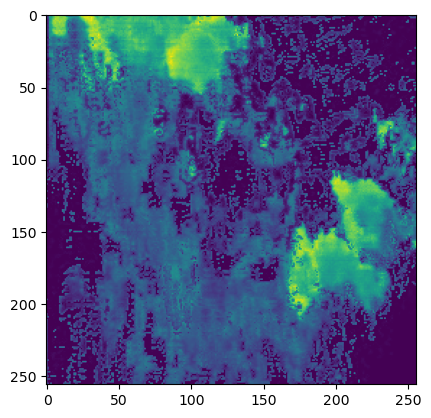

In [24]:
plt.imshow(img[0,:,:])

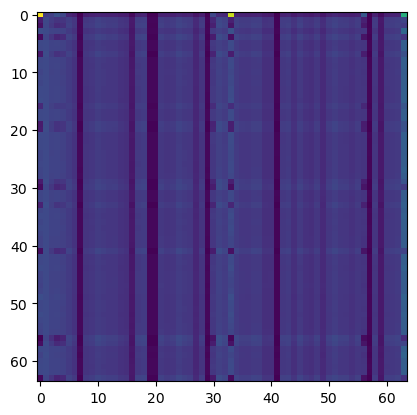

In [42]:
plt.imshow(temp[0,5,5,:-1,:-1])